# IMPORTS
Python modules used.

In [341]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import datetime
import numpy as np
import math
import reverse_geocoder as rg
from scipy.stats import norm
from scipy.stats import expon
from scipy.stats import lognorm
from scipy.stats import weibull_min
from scipy.stats import weibull_max
from scipy.stats import alpha
from scipy.stats import beta
import scipy.stats as stats
%matplotlib inline
from scipy import stats
from fitter import Fitter

#ignore deprication warnings
import warnings
warnings.filterwarnings('ignore')


# IMPORT DATA

For data reports: https://www.nohrsc.noaa.gov/nsa/reports.html

For definition of terms https://www.nohrsc.noaa.gov/help/

In [342]:
#read in the Surface Water Equivalent Data
SWE = pd.read_csv('swe.csv') 

# DATA CLEANING

In [343]:
# remove some unused columns
SWE = SWE.drop(["Unnamed: 0","Unnamed: 0.1", "Unnamed: 10", "Unnamed: 9","Zip_Code"], axis=1)

#remove the zeros
SWE = SWE[SWE.Amount>0]

# add columns for year,month,day
SWE['year'] = pd.DatetimeIndex(SWE['DateTime_Report(UTC)']).year
SWE['month'] = pd.DatetimeIndex(SWE['DateTime_Report(UTC)']).month
SWE['day'] = pd.DatetimeIndex(SWE['DateTime_Report(UTC)']).day

# Add a column that counts the number of entries from each station
SWE['StationCounts'] = SWE.groupby(['Station_Id'])['Station_Id'].transform('count')

# throw away the stations with less than 'mincount' data points?
mincount = 100
SWE = SWE[SWE['StationCounts']>mincount]

# Make a copy of the dataframe with only unique stations for plotting on a map.
SWE_Stations = SWE.drop_duplicates('Station_Id',keep='first')


In [344]:
#drop all stations outside of MA
#THIS TAKES A WHILE, ONLY USED FOR SHOWING THE MAP PLOT OF STATIONS

rows_to_delete=[]
for i, row in enumerate(SWE_Stations.itertuples(), 1):
    #print(i,row.Index)
    coords = (SWE_Stations.iloc[i-1]['Latitude'],SWE_Stations.iloc[i-1]['Longitude'])
    results = rg.search(coords)
    if results[0]['admin1'] != "Massachusetts":
        rows_to_delete.append(row.Index)
SWE_Stations = SWE_Stations.drop(rows_to_delete)

In [345]:
#plot the stations on a map
fig = px.scatter_mapbox(SWE_Stations, lon="Longitude", lat="Latitude", hover_name="Station_Id", hover_data=["Station_Id","StationCounts"],
                        zoom=4, height=300,color="StationCounts",color_continuous_scale=px.colors.sequential.Viridis)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
print("Plot of sites in MA")
fig.show()

Plot of sites in MA


In [346]:
#GET ANNUAL SWE MAXIMUMS (For each station)
#GET MONTHLY SWE MAXIMUMS (For each station)
#The entire row that governs is carried forward
    
MONTHLY_DATA=pd.DataFrame() 
ANNUAL_DATA=pd.DataFrame() 

#for all stations?
#for station in set(SWE_Stations['Station_Id']):

#select the station with the most data       
for station in ['GRFM3']:
    for yr in range(2006,2020):
        tmp1 = SWE[(SWE['year']==yr) & (SWE['Station_Id']==station)]
        try:
            ANNUAL_DATA = ANNUAL_DATA.append(tmp1.loc[tmp1['Amount'].idxmax()])
        except:
            pass
        
        for month in range(1,13):
            tmp2 = SWE[(SWE['year']==yr) & (SWE['month']==month) & (SWE['Station_Id']==station)]
            try:
                MONTHLY_DATA = MONTHLY_DATA.append(tmp2.loc[tmp2['Amount'].idxmax()])
            except:
                pass

            
#limit monthly data to full years
MONTHLY_DATA = MONTHLY_DATA[(MONTHLY_DATA['year']>2007)]            

#drop some columns no longer needed
ANNUAL_DATA = ANNUAL_DATA.drop(["StationCounts","Latitude", "Longitude"], axis=1)
MONTHLY_DATA = MONTHLY_DATA.drop(["StationCounts","Latitude", "Longitude"], axis=1)

In [347]:
#for the purposes of plotting put in zeros for months without data
for yr in range(2007,2020):
    for month in range(1,13):
        tmp = MONTHLY_DATA[(MONTHLY_DATA['year']==yr) & (MONTHLY_DATA['month']==month)]
        #print(tmp.shape[0])
        if tmp.shape[0]==0:
            #add a zero.
            #'2006-11-25 16'
            dfadd = pd.DataFrame([[yr,month,15,0,str(yr)+"-"+"%02i" %month+"-01 00"]], columns = ['year','month','day','Amount','DateTime_Report(UTC)'])
            MONTHLY_DATA=MONTHLY_DATA.append(dfadd)
MONTHLY_DATA = MONTHLY_DATA.sort_values(by=['DateTime_Report(UTC)'])

In [349]:
#Plot the data over time

fig = go.Figure()
fig.add_trace(go.Line(x=MONTHLY_DATA['DateTime_Report(UTC)'], y=MONTHLY_DATA['Amount'],
                    mode='lines',marker=dict(color='red',size=8),line_shape='hvh',
                    name='Monthly Maximum Data'))
fig.add_trace(go.Line(x=ANNUAL_DATA['DateTime_Report(UTC)'], y=ANNUAL_DATA['Amount'],
                    mode='lines',marker=dict(color='black',size=8),line_shape='hvh',
                    name='Annual Maximum Data'))

fig.update_layout(
    title="Annual & Monthly Maximum SWE Data",
    xaxis_title="Date",
    yaxis_title="SWE (inches of water)",
    template='plotly_white')
fig.show() 


In [350]:
#remove the zeros
ANNUAL_DATA = ANNUAL_DATA[ANNUAL_DATA.Amount>0]
MONTHLY_DATA = MONTHLY_DATA[MONTHLY_DATA.Amount>0]


# FIT A DISTRIBUTION (ANNUAL DATA)

## Test Fits

In [351]:
swe_vals_annual = sorted(list(ANNUAL_DATA["Amount"]))
h20 = 5.202288 #psf per inch of depth
weight_vals_annual = [i*h20 for i in swe_vals_annual]
n=len(weight_vals_annual)

## All Fits

Fitted alpha distribution with error=0.08685126952939777)
Fitted anglit distribution with error=0.04883481085775363)
Fitted arcsine distribution with error=0.046338382388063)
Fitted argus distribution with error=0.04933860996903499)
Fitted beta distribution with error=0.04612168732793427)
Fitted betaprime distribution with error=0.044276957677146234)
Fitted bradford distribution with error=0.04576993593927526)
Fitted burr distribution with error=0.045031594893389294)
Fitted burr12 distribution with error=0.044602696861021106)
Fitted cauchy distribution with error=0.04766762442082649)
Fitted chi distribution with error=0.050079347380275266)
Fitted chi2 distribution with error=0.04421859498360014)
Fitted cosine distribution with error=0.04887492361474255)
Fitted crystalball distribution with error=0.048896800520849854)
Fitted dgamma distribution with error=0.04855442337750831)
Fitted dweibull distribution with error=0.04839116101072124)
Fitted erlang distribution with error=0.04433814291

,sumsquare_error
mielke,0.043758
f,0.043949
exponpow,0.044044
chi2,0.044219
betaprime,0.044277


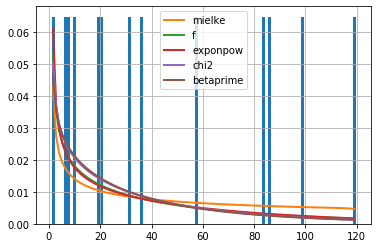

In [352]:
#try the fitter module

data_array = np.asarray(weight_vals_annual)
f = Fitter(data_array)
f.fit()
f.summary()

In [353]:
best_fits = ['mielke','f','exponpow','chi2','betaprime']

## Show the Fit

In [354]:
ErrorThreshold = 0.045

fig = go.Figure()
    
DISTRIBUTIONS = [stats.alpha,stats.anglit,stats.arcsine,stats.argus,stats.beta,stats.betaprime,stats.bradford,stats.burr,stats.burr12,stats.cauchy,stats.chi,stats.chi2,stats.cosine,stats.crystalball,stats.dgamma,stats.dweibull,stats.erlang,stats.expon,stats.exponnorm,stats.exponpow,stats.exponweib,stats.f,stats.fatiguelife,stats.fisk,stats.foldcauchy,stats.foldnorm,stats.frechet_l,stats.frechet_r,stats.gamma,stats.gausshyper,stats.genexpon,stats.genextreme,stats.gengamma,stats.genhalflogistic,stats.genlogistic,stats.gennorm,stats.genpareto,stats.gilbrat,stats.gompertz,stats.gumbel_l,stats.gumbel_r,stats.halfcauchy,stats.halfgennorm,stats.halflogistic,stats.halfnorm,stats.hypsecant,stats.invgamma,stats.invgauss,stats.invweibull,stats.johnsonsb,stats.johnsonsu,stats.kappa3,stats.kappa4,stats.ksone,stats.kstwobign,stats.laplace,stats.levy,stats.levy_l,stats.levy_stable,stats.loggamma,stats.logistic,stats.loglaplace,stats.lognorm,stats.lomax,stats.maxwell,stats.mielke,stats.moyal,stats.nakagami,stats.ncf,stats.nct,stats.ncx2,stats.norm,stats.norminvgauss,stats.pareto,stats.pearson3,stats.powerlaw,stats.powerlognorm,stats.powernorm,stats.rayleigh,stats.rdist,stats.recipinvgauss,stats.reciprocal,stats.rice,stats.rv_continuous,stats.rv_histogram,stats.semicircular,stats.skewnorm,stats.t,stats.trapz,stats.triang,stats.truncexpon,stats.truncnorm,stats.tukeylambda,stats.uniform,stats.vonmises,stats.vonmises_line,stats.wald,stats.weibull_max,stats.weibull_min,stats.wrapcauchy]
DIST_NAMES = ['alpha','anglit','arcsine','argus','beta','betaprime','bradford','burr','burr12','cauchy','chi','chi2','cosine','crystalball','dgamma','dweibull','erlang','expon','exponnorm','exponpow','exponweib','f','fatiguelife','fisk','foldcauchy','foldnorm','frechet_l','frechet_r','gamma','gausshyper','genexpon','genextreme','gengamma','genhalflogistic','genlogistic','gennorm','genpareto','gilbrat','gompertz','gumbel_l','gumbel_r','halfcauchy','halfgennorm','halflogistic','halfnorm','hypsecant','invgamma','invgauss','invweibull','johnsonsb','johnsonsu','kappa3','kappa4','ksone','kstwobign','laplace','levy','levy_l','levy_stable','loggamma','logistic','loglaplace','lognorm','lomax','maxwell','mielke','moyal','nakagami','ncf','nct','ncx2','norm','norminvgauss','pareto','pearson3','powerlaw','powerlognorm','powernorm','rayleigh','rdist','recipinvgauss','reciprocal','rice','rv_continuous','rv_histogram','semicircular','skewnorm','t','trapz','triang','truncexpon','truncnorm','tukeylambda','uniform','vonmises','vonmises_line','wald','weibull_max','weibull_min','wrapcauchy']
skips = ['wrapcauchy','genhalflogistic','gennorm','anglit','weibull_max','argus','reciprocal','semicircular','trapz','truncnorm','vonmises','frechet_l','frechet_r','chi2','ncx2','rdist','levy_l']
for i in range(len(DIST_NAMES)):
    #print(DIST_NAMES[i])
    if DIST_NAMES[i] not in skips:
        error = f.df_errors['sumsquare_error'][DIST_NAMES[i]]
        if np.isnan(error) or error>ErrorThreshold:
            visible='legendonly'
        else:
            visible=True
        
        try:
            name = DIST_NAMES[i]
            dist = DISTRIBUTIONS[i]
            params = f.fitted_param[name]

            yy = x=np.linspace(0.001,0.999,98)
            xx = [dist.ppf(i, *params) for i in yy]
            fig.add_trace(go.Scatter(x=xx, y=yy, line=dict(width=1),hoverinfo='name+text',
                                mode='lines',hovertext="%.4f" % error,visible=visible,name=name))
        except KeyError:
            pass

        
fig.add_trace(go.Scatter(x=sorted(weight_vals_annual), y=Pvals_annual,
                    mode='markers',marker=dict(color='black',size=8),
                    name='data from station: GRFM3'))

fig.update_layout(
    title="Fitting Distributions to Annual Maximum Data",
    xaxis_title="Annual Maximum Measured Snow Weight (psf)",
    yaxis_title="Probability",
    template='plotly_white')
fig.update_xaxes(range=[0, 140])
fig.show() 

These don't appear to fit very well, since the fit is based on the histogram (pdf) and there isn't enough data here to make a decent histogram.

## Estimate 50yr MRI

In [355]:
#use the best fit distributions to estimate the 50yr MRI event. 
ErrorThreshold = 0.0445
best_fits=[]
for i in range(len(DIST_NAMES)):
    #print(DIST_NAMES[i])
    if DIST_NAMES[i] not in skips:
        error = f.df_errors['sumsquare_error'][DIST_NAMES[i]]
        if not np.isnan(error) and error<ErrorThreshold:
            #print(DIST_NAMES[i],error)
            best_fits.append(DIST_NAMES[i])
#best_fits
print("\t\t50yr MRI Snow Load from Annual Maximums")
for fit in best_fits:
    i = DIST_NAMES.index(fit)
    dist = DISTRIBUTIONS[i]
    params = f.fitted_param[fit]
    yy = 0.98
    xx = dist.ppf(yy, *params)
    print("%20s"%fit,"\t","%.2f" %xx,"psf")


		50yr MRI Snow Load from Annual Maximums
           betaprime 	 194.15 psf
              erlang 	 164.50 psf
            exponpow 	 182.63 psf
                   f 	 230.43 psf
              mielke 	 120.40 psf
            nakagami 	 143.84 psf
            pearson3 	 156.89 psf


# FIT A DISTRIBUTION (MONTHLY DATA)

In [356]:
#repeat with monthly data
swe_vals_monthly = sorted(list(MONTHLY_DATA["Amount"]))
h20 = 5.202288 #psf per inch of depth
weight_vals_monthly = [i*h20 for i in swe_vals_monthly]
n=len(weight_vals_monthly)   

Fitted alpha distribution with error=0.030378671268127724)
Fitted anglit distribution with error=0.03611226030014285)
Fitted arcsine distribution with error=0.041872352653102615)
Fitted argus distribution with error=0.04272546709681305)
Fitted beta distribution with error=0.03796540435286635)
Fitted betaprime distribution with error=0.030500659999935318)
Fitted bradford distribution with error=0.03606329486346267)
Fitted burr distribution with error=0.03036143604425971)
Fitted burr12 distribution with error=0.03046550162500296)
Fitted cauchy distribution with error=0.03239186492665694)
Fitted chi distribution with error=0.03473889099897301)
Fitted chi2 distribution with error=0.03311965132966717)
Fitted cosine distribution with error=0.04005465100742985)
Fitted crystalball distribution with error=0.038430094038796866)
Fitted dgamma distribution with error=0.033244812892114686)
Fitted dweibull distribution with error=0.0332052681522768)
Fitted erlang distribution with error=0.0484853320

,sumsquare_error
johnsonsu,0.029689
mielke,0.030345
nct,0.030358
burr,0.030361
genextreme,0.030373


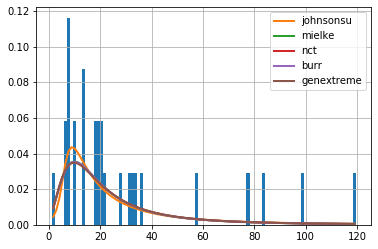

In [357]:
Pvals_monthly = []
X = []

for i in range(len(sorted(weight_vals_monthly))):
    Pvals_monthly.append(i/(n+1))
    X.append(weight_vals_monthly[i])
    
yy = x=np.linspace(0.001,0.999,98)


data_array_monthly = np.asarray(weight_vals_monthly)
f2 = Fitter(data_array_monthly)
f2.fit()
f2.summary()


In [358]:
fig = go.Figure()

ErrorThreshold = 0.033

skips = ['genhalflogistic','gennorm','anglit','weibull_max','argus','reciprocal','semicircular','trapz','truncnorm','vonmises','frechet_l','frechet_r','chi2','ncx2','rdist','levy_l']

for i in range(len(DIST_NAMES)):
    #print(DIST_NAMES[i])
    if DIST_NAMES[i] not in skips:
        error = f2.df_errors['sumsquare_error'][DIST_NAMES[i]]
        if np.isnan(error) or error>ErrorThreshold:
            visible='legendonly'
        else:
            visible=True
        
        try:
            name = DIST_NAMES[i]
            dist = DISTRIBUTIONS[i]
            params = f2.fitted_param[name]

            yy = np.linspace(0.001,0.999,98)
            xx = [dist.ppf(i, *params) for i in yy]
            fig.add_trace(go.Scatter(x=xx, y=yy, line=dict(width=1),hoverinfo='name+text',
                                mode='lines',hovertext="%.4f" % error,visible=visible,name=name))
        except KeyError:
            pass

        
fig.add_trace(go.Scatter(x=sorted(weight_vals_monthly), y=Pvals_monthly,
                    mode='markers',marker=dict(color='black',size=8),
                    name='data from station: GRFM3'))

fig.update_layout(
    title="Fitting Distributions to Monthly Maximum Data",
    xaxis_title="Monthly Maximum Measured Snow Weight (psf)",
    yaxis_title="Probability",
    template='plotly_white')
fig.update_xaxes(range=[0, 140])
fig.show() 

In [359]:
#use these distributions to estimate the 50yr MRI event. 

ErrorThreshold = 0.0304
best_fits=[]
for i in range(len(DIST_NAMES)):
    #print(DIST_NAMES[i])
    if DIST_NAMES[i] not in skips:
        error = f2.df_errors['sumsquare_error'][DIST_NAMES[i]]
        if not np.isnan(error) and error<ErrorThreshold:
            #print(DIST_NAMES[i],error)
            best_fits.append(DIST_NAMES[i])

#annual
#  0.98 = 1 - (1/50)

#monthly (considering 12 months per year)
#  0.9983 = 1 - (1/(12*50)

#monthly (considering 2.4 months per year)
#  0.9917 = 1 - (1/(2.4*50)

months_per_year = MONTHLY_DATA.shape[0]/(MONTHLY_DATA['year'].max()-MONTHLY_DATA['year'].min()+1)
yy = 1 - (1/(months_per_year*50))
#print(months_per_year,yy,"\n\n")
print("\t\t50yr MRI Snow Load from Monthly Maximums")
for fit in best_fits:
    i = DIST_NAMES.index(fit)
    dist = DISTRIBUTIONS[i]
    params = f2.fitted_param[fit]
    xx = dist.ppf(yy, *params)
    print("%20s"%fit,"\t","%.2f" %xx,"psf")

		50yr MRI Snow Load from Monthly Maximums
               alpha 	 438.12 psf
                burr 	 254.41 psf
          genextreme 	 235.93 psf
          invweibull 	 235.93 psf
           johnsonsu 	 237.54 psf
              mielke 	 249.94 psf
                 nct 	 241.88 psf


# Discussion
These values are so high, I must have something wrong in here.

ASCE 7 ground snow load is 50psf. I'm estimating 120 - 230 psf with annual data and 235 - 440 psf with monthly data. 

# UNUSED

In [360]:
#THIS BLOCK NO LONGER NEEDED

skip = '''
#NORMAL
Norm = []
mu = np.mean(weight_vals_annual)
#sample std
sigma = np.std(weight_vals_annual,ddof=1)
COV = sigma/mu
#print(mu,sigma,COV)

#LOGNORMAL
Lognorm = []
lam = np.log(mu/(1+COV**2)**0.5)
zeta = np.log(1+COV**2)

#EXPONENTIAL
Exp = []

#GUMBEL
Gumbel = []
Galpha = (math.pi/6**0.5)*(1/sigma)
u = mu - 0.5772/Galpha

#WEIBULL_MIN
WeibullM = []
WMc=0.75596
WMloc=0
WMScale=42.025

WeibullM3 = []
WM3c=0.89814
WM3loc=1.0405
WM3Scale=39.352


#WEIBULL_MAX
WeibullX = []
WXc = 0.20925214331029632
WXloc = 119.65262400000002
WXScale = 1.6797772925325134

#ALPHA
Alpha=[]
Aa= 2.061961519176622
Aloc = -17.373594069032166
Ascale = 75.09619917865092

#BETA
Beta = []
Ba1=0.37979
Ba2=0.65676
Ba=1.0405
Bb=119.65

Pvals_annual = []
X = []

for i in range(len(sorted(weight_vals_annual))):
    Pvals_annual.append(i/(n+1))
    X.append(weight_vals_annual[i])
yy = x=np.linspace(0.001,0.999,98)
for i in range(len(sorted(yy))):
    Norm.append(mu+sigma*norm.ppf(yy[i]))
    Lognorm.append(np.exp(lam+zeta*norm.ppf(yy[i])))
    Exp.append(mu*(-np.log(1-yy[i])))
    Gumbel.append((np.log(-np.log(yy[i])))/-Galpha + u)
    WeibullM.append(weibull_min.ppf(yy[i], WMc, loc=WMloc, scale=WMScale))
    WeibullM3.append(weibull_min.ppf(yy[i], WM3c, loc=WM3loc, scale=WM3Scale))
    Alpha.append(alpha.ppf(yy[i], Aa, loc=Aloc, scale=Ascale))
    Beta.append(beta.ppf(yy[i], Ba1, Ba2, Ba, Bb))

########################
# PLOT
########################

fig = go.Figure()
fig.add_trace(go.Scatter(x=X, y=Pvals_annual,
                    mode='markers',marker=dict(color='black',size=8),
                    name='data from station: GRFM3'))
fig.add_trace(go.Scatter(x=Norm, y=yy, line=dict(width=1),
                    mode='lines',
                    name='Normal'))
fig.add_trace(go.Scatter(x=Lognorm, y=yy, line=dict(width=1),
                    mode='lines',
                    name='Lognormal'))
fig.add_trace(go.Scatter(x=Exp, y=yy, line=dict(width=1),
                    mode='lines',
                    name='Exponential'))
fig.add_trace(go.Scatter(x=Gumbel, y=yy, line=dict(width=1),
                    mode='lines',
                    name='Gumbel'))
fig.add_trace(go.Scatter(x=WeibullM, y=yy, line=dict(width=1),
                    mode='lines',
                    name='Weibull'))
fig.add_trace(go.Scatter(x=WeibullM3, y=yy, line=dict(width=1),
                    mode='lines',
                    name='Weibull3'))
fig.add_trace(go.Scatter(x=Alpha, y=yy, line=dict(width=1),
                    mode='lines',
                    name='Alpha'))
fig.add_trace(go.Scatter(x=Beta, y=yy, line=dict(width=1),
                    mode='lines',
                    name='Beta'))             
fig.update_layout(
    title="Fitting Distributions to Annual Maximum Data",
    xaxis_title="Annual Maximum Measured Snow Weight (psf)",
    yaxis_title="Probability",
    template='plotly_white')
fig.update_xaxes(range=[0, 140])
fig.show()
'''